In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_excel('/Users/stevenmacauda/Downloads/Sample - Superstore.xls')

In [4]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [5]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

In [6]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [7]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

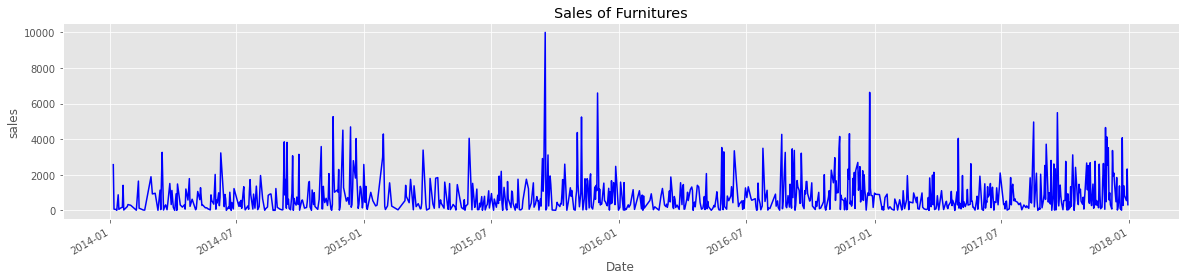

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [9]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

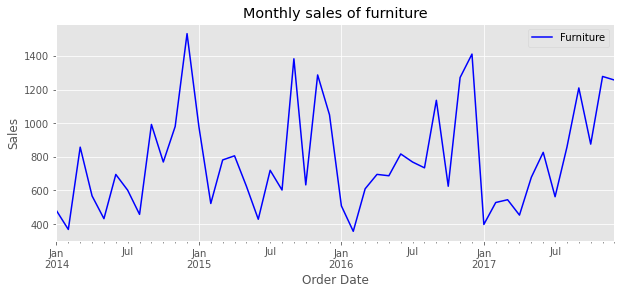

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [11]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [12]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [13]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [14]:
n_input = 12
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [16]:
######
#set the counter to repeat
n=3
store= np.zeros((12,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
    #Add layer
    model_vanilla.add(Dense(100, activation='relu'))
    model_vanilla.add(Dense(100, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)
    
    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Epoch 1/200


2022-08-19 18:35:53.183187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 469ms/step - loss: 0.1861
Epoch 2/200
3/3 [==============================] - 1s 295ms/step - loss: 0.1406
Epoch 3/200
3/3 [==============================] - 1s 319ms/step - loss: 0.1049
Epoch 4/200
3/3 [==============================] - 1s 361ms/step - loss: 0.0778
Epoch 5/200
3/3 [==============================] - 1s 338ms/step - loss: 0.0672
Epoch 6/200
3/3 [==============================] - 1s 397ms/step - loss: 0.0683
Epoch 7/200
3/3 [==============================] - 1s 312ms/step - loss: 0.0827
Epoch 8/200
3/3 [==============================] - 1s 297ms/step - loss: 0.0901
Epoch 9/200
3/3 [==============================] - 1s 420ms/step - loss: 0.0827
Epoch 10/200
3/3 [==============================] - 1s 481ms/step - loss: 0.0733
Epoch 11/200
3/3 [==============================] - 1s 343ms/step - loss: 0.0679
Epoch 12/200
3/3 [==============================] - 1s 472ms/step - loss: 0.0656
Epoch 13/200
3/3 [==============================]

3/3 [==============================] - 1s 417ms/step - loss: 0.0340
Epoch 103/200
3/3 [==============================] - 1s 356ms/step - loss: 0.0333
Epoch 104/200
3/3 [==============================] - 1s 389ms/step - loss: 0.0324
Epoch 105/200
3/3 [==============================] - 1s 341ms/step - loss: 0.0329
Epoch 106/200
3/3 [==============================] - 1s 433ms/step - loss: 0.0321
Epoch 107/200
3/3 [==============================] - 1s 335ms/step - loss: 0.0338
Epoch 108/200
3/3 [==============================] - 1s 339ms/step - loss: 0.0306
Epoch 109/200
3/3 [==============================] - 1s 338ms/step - loss: 0.0315
Epoch 110/200
3/3 [==============================] - 1s 363ms/step - loss: 0.0309
Epoch 111/200
3/3 [==============================] - 1s 342ms/step - loss: 0.0306
Epoch 112/200
3/3 [==============================] - 1s 359ms/step - loss: 0.0307
Epoch 113/200
3/3 [==============================] - 1s 450ms/step - loss: 0.0298
Epoch 114/200
3/3 [===========

2022-08-19 18:39:38.447195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 59ms/step
Epoch 1/200


2022-08-19 18:39:41.068868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 405ms/step - loss: 0.1861
Epoch 2/200
3/3 [==============================] - 1s 373ms/step - loss: 0.1455
Epoch 3/200
3/3 [==============================] - 1s 371ms/step - loss: 0.1080
Epoch 4/200
3/3 [==============================] - 1s 369ms/step - loss: 0.0826
Epoch 5/200
3/3 [==============================] - 1s 389ms/step - loss: 0.0628
Epoch 6/200
3/3 [==============================] - 1s 490ms/step - loss: 0.0657
Epoch 7/200
3/3 [==============================] - 1s 437ms/step - loss: 0.0791
Epoch 8/200
3/3 [==============================] - 1s 398ms/step - loss: 0.0848
Epoch 9/200
3/3 [==============================] - 1s 509ms/step - loss: 0.0815
Epoch 10/200
3/3 [==============================] - 1s 432ms/step - loss: 0.0762
Epoch 11/200
3/3 [==============================] - 1s 405ms/step - loss: 0.0708
Epoch 12/200
3/3 [==============================] - 1s 454ms/step - loss: 0.0675
Epoch 13/200
3/3 [==============================]

3/3 [==============================] - 2s 584ms/step - loss: 0.0354
Epoch 103/200
3/3 [==============================] - 2s 593ms/step - loss: 0.0355
Epoch 104/200
3/3 [==============================] - 2s 677ms/step - loss: 0.0361
Epoch 105/200
3/3 [==============================] - 2s 749ms/step - loss: 0.0338
Epoch 106/200
3/3 [==============================] - 2s 768ms/step - loss: 0.0356
Epoch 107/200
3/3 [==============================] - 2s 790ms/step - loss: 0.0346
Epoch 108/200
3/3 [==============================] - 2s 759ms/step - loss: 0.0355
Epoch 109/200
3/3 [==============================] - 2s 781ms/step - loss: 0.0356
Epoch 110/200
3/3 [==============================] - 2s 751ms/step - loss: 0.0325
Epoch 111/200
3/3 [==============================] - 2s 724ms/step - loss: 0.0341
Epoch 112/200
3/3 [==============================] - 2s 708ms/step - loss: 0.0330
Epoch 113/200
3/3 [==============================] - 2s 778ms/step - loss: 0.0339
Epoch 114/200
3/3 [===========

2022-08-19 18:44:48.653266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 74ms/step
Epoch 1/200


2022-08-19 18:44:51.319611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 543ms/step - loss: 0.1863
Epoch 2/200
3/3 [==============================] - 1s 494ms/step - loss: 0.1421
Epoch 3/200
3/3 [==============================] - 1s 487ms/step - loss: 0.1049
Epoch 4/200
3/3 [==============================] - 2s 513ms/step - loss: 0.0748
Epoch 5/200
3/3 [==============================] - 1s 497ms/step - loss: 0.0717
Epoch 6/200
3/3 [==============================] - 2s 499ms/step - loss: 0.0701
Epoch 7/200
3/3 [==============================] - 1s 483ms/step - loss: 0.0895
Epoch 8/200
3/3 [==============================] - 1s 477ms/step - loss: 0.0871
Epoch 9/200
3/3 [==============================] - 2s 529ms/step - loss: 0.0789
Epoch 10/200
3/3 [==============================] - 1s 477ms/step - loss: 0.0735
Epoch 11/200
3/3 [==============================] - 1s 474ms/step - loss: 0.0668
Epoch 12/200
3/3 [==============================] - 1s 482ms/step - loss: 0.0658
Epoch 13/200
3/3 [==============================]

3/3 [==============================] - 1s 475ms/step - loss: 0.0351
Epoch 103/200
3/3 [==============================] - 1s 473ms/step - loss: 0.0361
Epoch 104/200
3/3 [==============================] - 1s 477ms/step - loss: 0.0363
Epoch 105/200
3/3 [==============================] - 1s 480ms/step - loss: 0.0359
Epoch 106/200
3/3 [==============================] - 1s 475ms/step - loss: 0.0348
Epoch 107/200
3/3 [==============================] - 2s 502ms/step - loss: 0.0349
Epoch 108/200
3/3 [==============================] - 2s 509ms/step - loss: 0.0343
Epoch 109/200
3/3 [==============================] - 1s 484ms/step - loss: 0.0335
Epoch 110/200
3/3 [==============================] - 1s 475ms/step - loss: 0.0334
Epoch 111/200
3/3 [==============================] - 1s 475ms/step - loss: 0.0347
Epoch 112/200
3/3 [==============================] - 1s 472ms/step - loss: 0.0328
Epoch 113/200
3/3 [==============================] - 2s 525ms/step - loss: 0.0331
Epoch 114/200
3/3 [===========

2022-08-19 18:49:50.507993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 66ms/step
[[ 807.36900299  611.7880385   547.53930343]
 [ 528.64310914  434.57929016  409.87691434]
 [ 297.66249995  401.62087162  317.3363811 ]
 [ 406.87593071  590.12054273  434.71904452]
 [ 600.87465742  703.15722911  575.00288318]
 [ 775.9745932   840.54867445  819.73089711]
 [ 795.32991534  796.560083    828.55460106]
 [ 867.01642337  796.79261576  884.64652618]
 [ 973.88824171 1089.19471476 1209.38227394]
 [ 770.35138497  617.34295468  758.79270622]
 [1151.96132496 1263.09082585 1305.3651275 ]
 [1175.23505881 1570.1844203  1464.25233137]]


In [17]:
final_vanilla= np.zeros((store.shape[0],1))

#final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((12,))

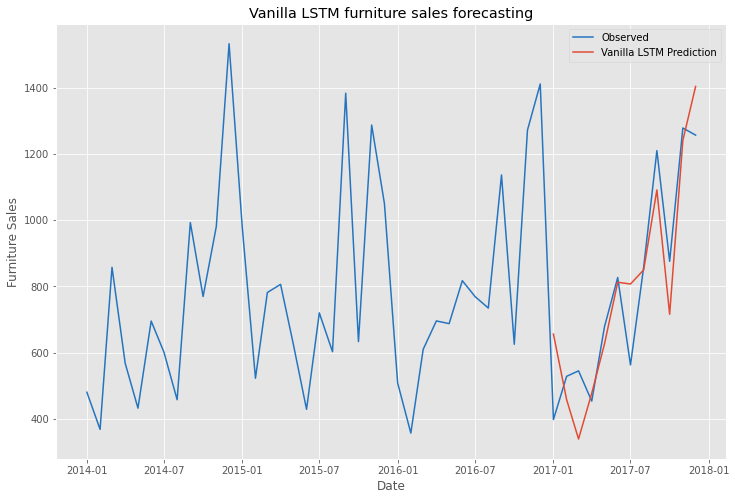

In [18]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [19]:
vanilla_lstm= performance(df[-12:],final_vanilla)
vanilla_lstm

{'MSE': 19978.66, 'RMSE': 141.35, 'MAPE': 18.15}

In [20]:
######
n=3
store2= np.zeros((12,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
    model_stacked.add(LSTM(50, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(50, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)
    
    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list_s.append(model_stacked.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Epoch 1/200


2022-08-19 20:29:41.182321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 5s 952ms/step - loss: 0.1897
Epoch 2/200
3/3 [==============================] - 2s 796ms/step - loss: 0.1493
Epoch 3/200
3/3 [==============================] - 2s 888ms/step - loss: 0.1101
Epoch 4/200
3/3 [==============================] - 2s 662ms/step - loss: 0.0741
Epoch 5/200
3/3 [==============================] - 2s 689ms/step - loss: 0.0596
Epoch 6/200
3/3 [==============================] - 2s 741ms/step - loss: 0.0785
Epoch 7/200
3/3 [==============================] - 2s 759ms/step - loss: 0.0918
Epoch 8/200
3/3 [==============================] - 3s 943ms/step - loss: 0.0836
Epoch 9/200
3/3 [==============================] - 2s 793ms/step - loss: 0.0728
Epoch 10/200
3/3 [==============================] - 2s 733ms/step - loss: 0.0672
Epoch 11/200
3/3 [==============================] - 3s 907ms/step - loss: 0.0650
Epoch 12/200
3/3 [==============================] - 3s 831ms/step - loss: 0.0656
Epoch 13/200
3/3 [==============================]

3/3 [==============================] - 3s 931ms/step - loss: 0.0341
Epoch 103/200
3/3 [==============================] - 3s 1s/step - loss: 0.0325
Epoch 104/200
3/3 [==============================] - 3s 1s/step - loss: 0.0330
Epoch 105/200
3/3 [==============================] - 4s 1s/step - loss: 0.0318
Epoch 106/200
3/3 [==============================] - 3s 1s/step - loss: 0.0333
Epoch 107/200
3/3 [==============================] - 3s 895ms/step - loss: 0.0326
Epoch 108/200
3/3 [==============================] - 3s 858ms/step - loss: 0.0333
Epoch 109/200
3/3 [==============================] - 3s 943ms/step - loss: 0.0329
Epoch 110/200
3/3 [==============================] - 3s 879ms/step - loss: 0.0328
Epoch 111/200
3/3 [==============================] - 3s 884ms/step - loss: 0.0308
Epoch 112/200
3/3 [==============================] - 3s 890ms/step - loss: 0.0336
Epoch 113/200
3/3 [==============================] - 2s 807ms/step - loss: 0.0316
Epoch 114/200
3/3 [=======================

2022-08-19 20:38:32.351992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 98ms/step
Epoch 1/200


2022-08-19 20:38:36.032454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 5s 898ms/step - loss: 0.1887
Epoch 2/200
3/3 [==============================] - 3s 860ms/step - loss: 0.1502
Epoch 3/200
3/3 [==============================] - 3s 954ms/step - loss: 0.1115
Epoch 4/200
3/3 [==============================] - 3s 902ms/step - loss: 0.0780
Epoch 5/200
3/3 [==============================] - 3s 943ms/step - loss: 0.0663
Epoch 6/200
3/3 [==============================] - 3s 952ms/step - loss: 0.0831
Epoch 7/200
3/3 [==============================] - 3s 937ms/step - loss: 0.0907
Epoch 8/200
3/3 [==============================] - 3s 1s/step - loss: 0.0804
Epoch 9/200
3/3 [==============================] - 3s 1s/step - loss: 0.0706
Epoch 10/200
3/3 [==============================] - 3s 1s/step - loss: 0.0659
Epoch 11/200
3/3 [==============================] - 3s 970ms/step - loss: 0.0645
Epoch 12/200
3/3 [==============================] - 3s 915ms/step - loss: 0.0647
Epoch 13/200
3/3 [==============================] - 3s 965

3/3 [==============================] - 3s 947ms/step - loss: 0.0348
Epoch 104/200
3/3 [==============================] - 3s 952ms/step - loss: 0.0341
Epoch 105/200
3/3 [==============================] - 3s 908ms/step - loss: 0.0358
Epoch 106/200
3/3 [==============================] - 3s 892ms/step - loss: 0.0345
Epoch 107/200
3/3 [==============================] - 3s 950ms/step - loss: 0.0341
Epoch 108/200
3/3 [==============================] - 3s 951ms/step - loss: 0.0334
Epoch 109/200
3/3 [==============================] - 3s 882ms/step - loss: 0.0333
Epoch 110/200
3/3 [==============================] - 3s 965ms/step - loss: 0.0330
Epoch 111/200
3/3 [==============================] - 3s 951ms/step - loss: 0.0338
Epoch 112/200
3/3 [==============================] - 3s 920ms/step - loss: 0.0328
Epoch 113/200
3/3 [==============================] - 3s 933ms/step - loss: 0.0324
Epoch 114/200
3/3 [==============================] - 3s 1s/step - loss: 0.0319
Epoch 115/200
3/3 [==============

2022-08-19 20:48:22.348491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 114ms/step
Epoch 1/200


2022-08-19 20:48:26.303795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 5s 994ms/step - loss: 0.1898
Epoch 2/200
3/3 [==============================] - 3s 893ms/step - loss: 0.1493
Epoch 3/200
3/3 [==============================] - 3s 918ms/step - loss: 0.1101
Epoch 4/200
3/3 [==============================] - 3s 984ms/step - loss: 0.0790
Epoch 5/200
3/3 [==============================] - 3s 1s/step - loss: 0.0606
Epoch 6/200
3/3 [==============================] - 3s 1s/step - loss: 0.0943
Epoch 7/200
3/3 [==============================] - 3s 1s/step - loss: 0.0987
Epoch 8/200
3/3 [==============================] - 3s 1s/step - loss: 0.0872
Epoch 9/200
3/3 [==============================] - 3s 1s/step - loss: 0.0678
Epoch 10/200
3/3 [==============================] - 3s 1s/step - loss: 0.0661
Epoch 11/200
3/3 [==============================] - 3s 1s/step - loss: 0.0642
Epoch 12/200
3/3 [==============================] - 3s 1s/step - loss: 0.0643
Epoch 13/200
3/3 [==============================] - 3s 1s/step - loss: 0.

Epoch 105/200
3/3 [==============================] - 3s 828ms/step - loss: 0.0372
Epoch 106/200
3/3 [==============================] - 3s 834ms/step - loss: 0.0332
Epoch 107/200
3/3 [==============================] - 3s 970ms/step - loss: 0.0353
Epoch 108/200
3/3 [==============================] - 3s 910ms/step - loss: 0.0412
Epoch 109/200
3/3 [==============================] - 3s 859ms/step - loss: 0.0382
Epoch 110/200
3/3 [==============================] - 3s 870ms/step - loss: 0.0418
Epoch 111/200
3/3 [==============================] - 3s 842ms/step - loss: 0.0337
Epoch 112/200
3/3 [==============================] - 3s 842ms/step - loss: 0.0345
Epoch 113/200
3/3 [==============================] - 3s 976ms/step - loss: 0.0371
Epoch 114/200
3/3 [==============================] - 3s 927ms/step - loss: 0.0345
Epoch 115/200
3/3 [==============================] - 3s 891ms/step - loss: 0.0403
Epoch 116/200
3/3 [==============================] - 3s 912ms/step - loss: 0.0353
Epoch 117/200
3/

2022-08-19 21:00:39.926516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 186ms/step
[[1014.55092809  708.32556571  704.96217796]
 [ 708.23515187  673.22597514  701.68111199]
 [ 352.9170976   335.3369582   387.28017643]
 [ 398.66945621  359.2319325   398.94345638]
 [ 488.17832782  455.64743957  456.77757751]
 [ 696.30129598  723.1090864   621.19070978]
 [ 719.95006685  788.1152344   770.41401958]
 [ 809.32633471  946.87303543  954.88816433]
 [1118.71159241 1097.88964643  984.21328477]
 [ 804.07406492  775.69305271  785.52213331]
 [1318.19016046 1544.84514537 1387.90157628]
 [1350.99269308 1533.12266379 1363.11641452]]


In [21]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):
    
    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((12,))

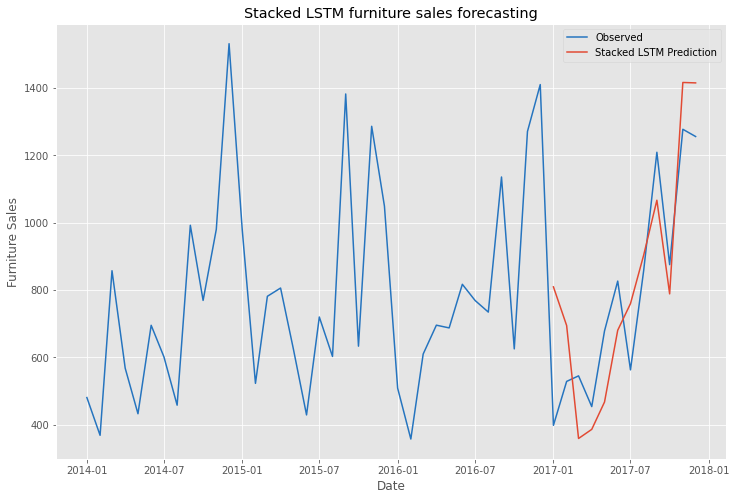

In [22]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [23]:
stacked_lstm= performance(df[-12:],final_stacked2)
stacked_lstm

{'MSE': 34666.84, 'RMSE': 186.19, 'MAPE': 26.55}

In [24]:
# define model
warnings.filterwarnings("ignore")
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [25]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200


2022-08-19 21:01:49.284364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 6s 782ms/step - loss: 0.1948
Epoch 2/200
3/3 [==============================] - 3s 800ms/step - loss: 0.1664
Epoch 3/200
3/3 [==============================] - 3s 928ms/step - loss: 0.1397
Epoch 4/200
3/3 [==============================] - 2s 708ms/step - loss: 0.1165
Epoch 5/200
3/3 [==============================] - 3s 796ms/step - loss: 0.0949
Epoch 6/200
3/3 [==============================] - 2s 754ms/step - loss: 0.0761
Epoch 7/200
3/3 [==============================] - 2s 715ms/step - loss: 0.0640
Epoch 8/200
3/3 [==============================] - 2s 658ms/step - loss: 0.0636
Epoch 9/200
3/3 [==============================] - 3s 861ms/step - loss: 0.0667
Epoch 10/200
3/3 [==============================] - 5s 2s/step - loss: 0.0761
Epoch 11/200
3/3 [==============================] - 3s 1s/step - loss: 0.0793
Epoch 12/200
3/3 [==============================] - 3s 927ms/step - loss: 0.0765
Epoch 13/200
3/3 [==============================] - 3s 

3/3 [==============================] - 3s 877ms/step - loss: 0.0223
Epoch 106/200
3/3 [==============================] - 3s 847ms/step - loss: 0.0223
Epoch 107/200
3/3 [==============================] - 2s 799ms/step - loss: 0.0201
Epoch 108/200
3/3 [==============================] - 2s 814ms/step - loss: 0.0204
Epoch 109/200
3/3 [==============================] - 3s 901ms/step - loss: 0.0179
Epoch 110/200
3/3 [==============================] - 3s 855ms/step - loss: 0.0232
Epoch 111/200
3/3 [==============================] - 3s 934ms/step - loss: 0.0174
Epoch 112/200
3/3 [==============================] - 3s 826ms/step - loss: 0.0168
Epoch 113/200
3/3 [==============================] - 3s 817ms/step - loss: 0.0181
Epoch 114/200
3/3 [==============================] - 3s 883ms/step - loss: 0.0183
Epoch 115/200
3/3 [==============================] - 3s 895ms/step - loss: 0.0199
Epoch 116/200
3/3 [==============================] - 3s 825ms/step - loss: 0.0167
Epoch 117/200
3/3 [===========

In [26]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])

2022-08-19 21:12:48.999534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 188ms/step


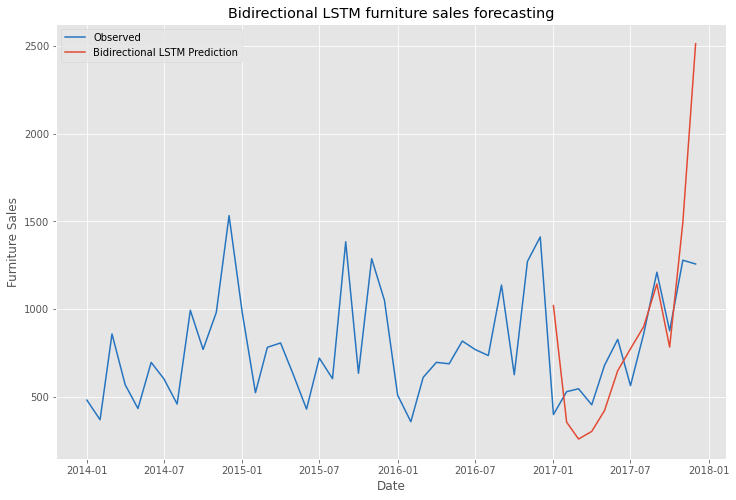

In [27]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [28]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm

{'MSE': 192023.2, 'RMSE': 438.2, 'MAPE': 42.52}

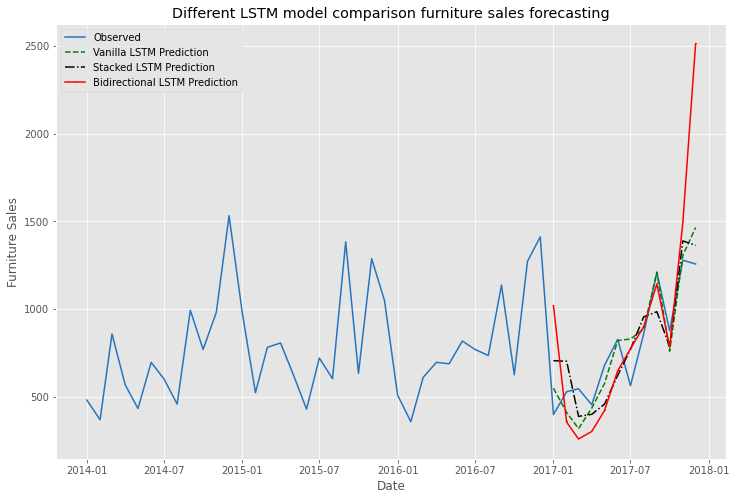

In [29]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()